In [1]:
# Spark setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, month, col

# Data science libs
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster
import pickle
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from scipy.stats import chi2_contingency

# Initialize Spark
spark = (SparkSession.builder
         .appName("CrimeAnalyticsDemo")
         .config("spark.sql.shuffle.partitions", "50")
         .getOrCreate())

# Base HDFS paths
clean_base = "hdfs://localhost:9000/user/yashwanthreddy/crime/clean"
processed_base = "hdfs://localhost:9000/user/yashwanthreddy/crime/processed"
eda_base   = "hdfs://localhost:9000/user/yashwanthreddy/crime/eda_output"
cluster_base = "hdfs://localhost:9000/user/yashwanthreddy/crime/clusters"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 00:46:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/10 00:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
street = (spark.read.parquet(f"{clean_base}/street")
          .withColumn("date", to_date(col("date"))))
print("Total street-level records:", street.count())

# Show a sample
street.limit(5).toPandas()


Total street-level records: 10399330


crime_id  \
0  112de9f67c401573cfc997d617e59f10a4c1d530518ab8...   
1                                               None   
2  1f0f5f4a9d46c429847db16723097ddf677e19729e1169...   
3                                               None   
4  7a2795bda56d7873434f2dc3d9cacd6ddf76d73269d39f...   

                          reported_by                        falls_within  \
0              nottinghamshire police              nottinghamshire police   
1  police service of northern ireland  police service of northern ireland   
2              nottinghamshire police              nottinghamshire police   
3  police service of northern ireland  police service of northern ireland   
4              nottinghamshire police              nottinghamshire police   

   longitude   latitude                location  lsoa_code        lsoa_name  \
0  -1.129023  52.933247  on or near supermarket  e01028416  rushcliffe 005d   
1  -6.336661  54.175910              on or near       None             None   
2  -1.129023  52.933247  on or near supermarket  e01028416  rushcliffe 005d   
3  -7.195616  54.234565              on or near       None             None   
4  -1.129023  52.933247  on or near supermarket  e01028416  rushcliffe 005d   

              crime_type                          last_outcome_category  \
0            shoplifting  investigation complete; no suspect identified   
1  anti-social behaviour                                           None   
2            shoplifting  investigation complete; no suspect identified   
3  anti-social behaviour                                           None   
4            shoplifting  investigation complete; no suspect identified   

  context        date  year  month  
0    None  2022-05-01  2022      5  
1    None  2022-05-01  2022      5  
2    None  2022-05-01  2022      5  
3    None  2022-05-01  2022      5  
4    None  2022-05-01  2022      5

In [3]:
# Helper to read any CSV summary into Pandas
def load_csv(path):
    return (spark.read.option("header",True)
                    .csv(path)
                    .toPandas())

# Crime type counts
ct = load_csv(f"{eda_base}/crime_type_counts")
display(ct)

# Top 10 LSOAs
lsoa = load_csv(f"{eda_base}/top10_lsoas")
display(lsoa)

# Distinct crime types
distinct = load_csv(f"{eda_base}/distinct_crime_types")
display(distinct)

# Coordinate stats
coords = load_csv(f"{eda_base}/coordinate_stats")
display(coords)


crime_type    count
0      criminal damage and arson   948394
1                  vehicle crime   545668
2                    shoplifting   656743
3   violence and sexual offences  4182041
4          possession of weapons   101773
5                       burglary   441037
6                   public order   978197
7                    other crime   213210
8                        robbery    89900
9          theft from the person    74257
10                         drugs   282712
11                   other theft   699381
12                 bicycle theft    97596
13         anti-social behaviour  1260059

lsoa_code            lsoa_name   count
0       None                 None  311959
1  e01033010           leeds 111b   22687
2  e01033620      birmingham 138a   15897
3  e01033760       liverpool 060c   15170
4  e01033756       liverpool 061c   11249
5  e01032867       leicester 041a   10650
6  e01033615      birmingham 135c    8218
7  e01013479           derby 013f    8192
8  e01033264       sheffield 073d    8050
9  e01014287  stoke-on-trent 015d    7974

distinct_crime_types
0                   14

min_latitude max_latitude min_longitude max_longitude       avg_latitude  \
0    49.892904    58.513585     -1.000002      1.760357  52.84220124978648   

        avg_longitude  
0  -2.069608452580723

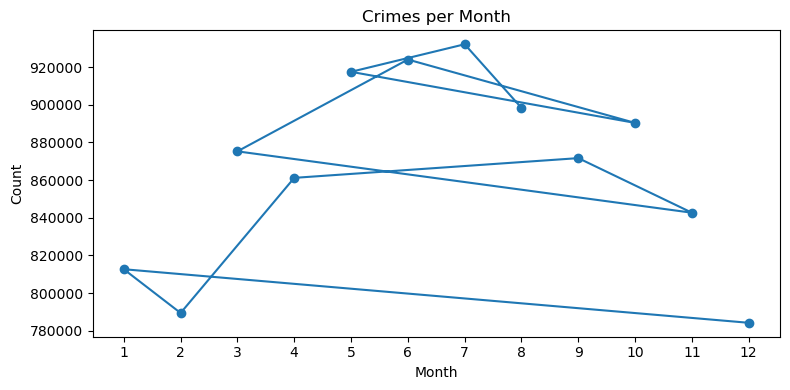

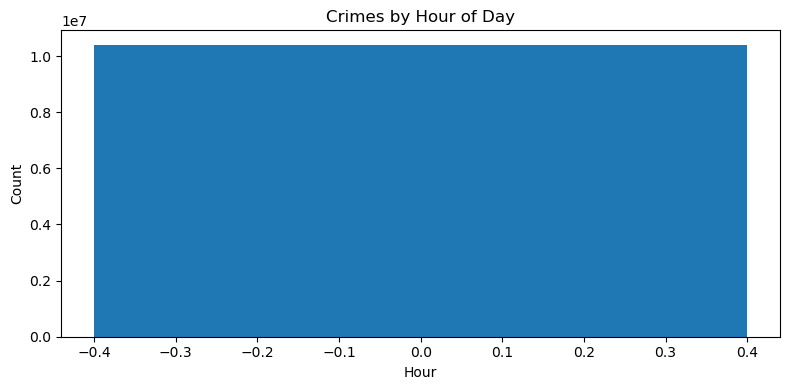

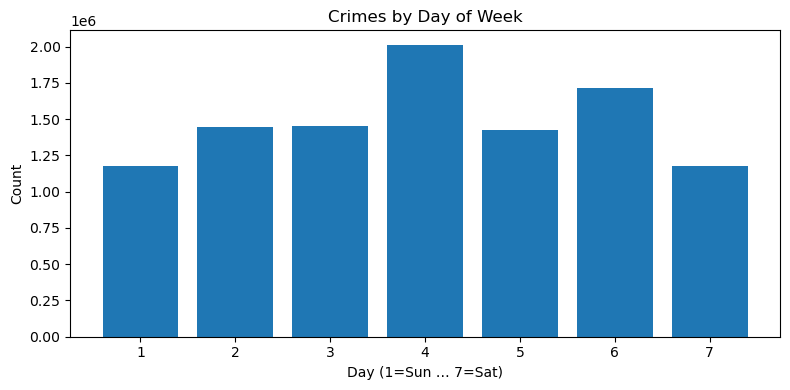

In [4]:
# Cell 5: Temporal Distributions (fixed)
monthly = load_csv(f"{eda_base}/counts_by_month")

# Convert columns to numeric just to be safe
monthly["month"] = monthly["month"].astype(int)
monthly["count"] = monthly["count"].astype(int)

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["count"], marker='o')
plt.title("Crimes per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(monthly["month"])  # ensure ticks for each month
plt.tight_layout()
plt.show()

# Hour of day
hour = load_csv(f"{eda_base}/counts_by_hour")
hour["hour"] = hour["hour"].astype(int)
hour["count"] = hour["count"].astype(int)

plt.figure(figsize=(8,4))
plt.bar(hour["hour"], hour["count"])
plt.title("Crimes by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Day of week
dow = load_csv(f"{eda_base}/counts_by_dow")
dow["dow"] = dow["dow"].astype(int)
dow["count"] = dow["count"].astype(int)

plt.figure(figsize=(8,4))
plt.bar(dow["dow"], dow["count"])
plt.title("Crimes by Day of Week")
plt.xlabel("Day (1=Sun … 7=Sat)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [5]:
# Load clustered data
dfc = (spark.read.parquet(f"{cluster_base}")
       .withColumn("latitude",  col("latitude").cast("double"))
       .withColumn("longitude", col("longitude").cast("double")))

pdf = dfc.select("latitude","longitude","prediction") \
         .sample(0.1, seed=42) \
         .toPandas()

# Compute centroids
centroids = pdf.groupby("prediction")[["latitude","longitude"]].mean().reset_index()

# Build Folium map
m = folium.Map(location=[pdf.latitude.mean(), pdf.longitude.mean()], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for _, r in pdf.iterrows():
    folium.CircleMarker(
        location=(r.latitude, r.longitude),
        radius=3,
        color=plt.cm.tab10(int(r.prediction)%10),
        fill=True, fill_opacity=0.6
    ).add_to(marker_cluster)

for _, r in centroids.iterrows():
    folium.Marker(
        location=(r.latitude, r.longitude),
        icon=folium.Icon(color="red"),
        popup=f"Cluster {int(r.prediction)}"
    ).add_to(m)

# Display inline (Jupyter will render this)
#m


χ² = 8684281.98, p = 0, dof = 156


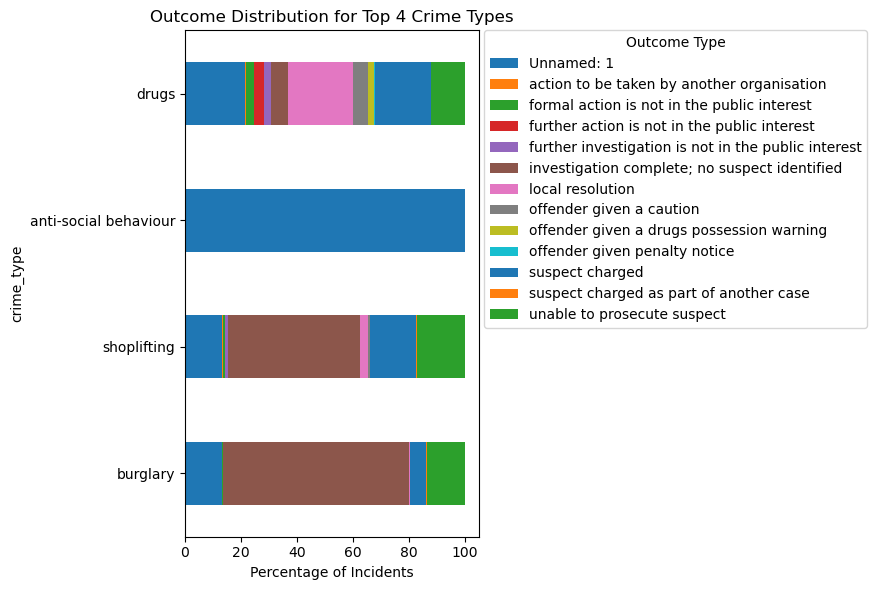

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import chi2_contingency

# 1. Load your pivot table
table = pd.read_csv(
    '/Users/yashwanthreddy/Desktop/My pc/sjsu/Sem2/Big_Data/GP/analysis/output/crime_outcome_crosstab.csv',
    index_col=0
).fillna(0)

# 2. Chi-square test (optional print)
chi2, p, dof, _ = chi2_contingency(table.values)
print(f"χ² = {chi2:.2f}, p = {p:.3g}, dof = {dof}")

# 3. Convert to percentages
percent = table.div(table.sum(axis=1), axis=0) * 100

# 4. Choose top 4 crime types by total incidents
top4 = percent.sum(axis=1).nlargest(4).index
plot_df = percent.loc[top4]

# 5. Plot horizontal stacked bars
fig, ax = plt.subplots(figsize=(12, 6))
plot_df.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    edgecolor='none'
)

# 6. Wrap long y‐tick labels
wrapped_labels = [textwrap.fill(lbl, 25) for lbl in plot_df.index]
ax.set_yticklabels(wrapped_labels)

# 7. Axis labels & title
ax.set_xlabel('Percentage of Incidents')
ax.set_title('Outcome Distribution for Top 4 Crime Types')

# 8. Move legend outside
ax.legend(
    title='Outcome Type',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

# 9. Tidy layout with extra space on the right
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()


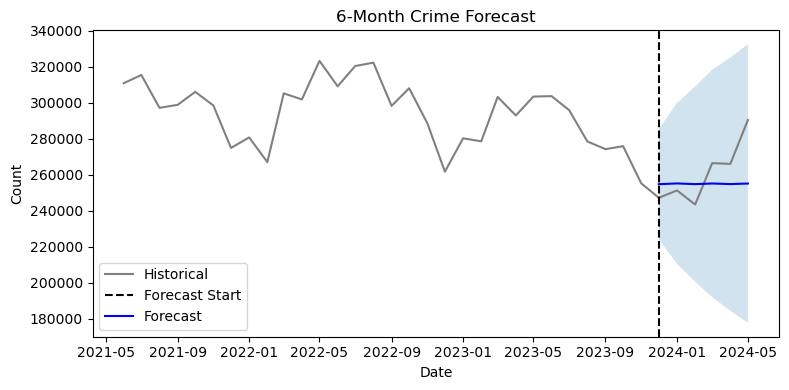

In [7]:
# --- Historical series from HDFS-loaded CSV ---

# 1. Read the year_month_trend CSV from HDFS
ym_spark = (spark.read
    .option("header", True)
    .csv(f"{eda_base}/year_month_trend"))

# 2. Cast columns to numeric
from pyspark.sql.functions import col
ym_spark = (ym_spark
    .withColumn("year",   col("year").cast("int"))
    .withColumn("month",  col("month").cast("int"))
    .withColumn("count",  col("count").cast("int")))

# 3. Convert to Pandas
ym = ym_spark.toPandas()

# 4. Build a proper datetime index
ym['date'] = pd.to_datetime(dict(
    year  = ym['year'],
    month = ym['month'],
    day   = 1
))
ym.set_index('date', inplace=True)
monthly_ts = ym['count'].sort_index()

# 5. Load the forecast CSV from local filesystem
fc = pd.read_csv(
    '/Users/yashwanthreddy/Desktop/My pc/sjsu/Sem2/Big_Data/GP/forecasting/output/forecast.csv',
    index_col=0, parse_dates=True
)

# 6. Plot history vs. forecast
plt.figure(figsize=(8,4))
plt.plot(monthly_ts, label="Historical", color="gray")
plt.axvline(x=fc.index[0], color="black", linestyle="--", label="Forecast Start")
plt.plot(fc["mean"], label="Forecast", color="blue")
plt.fill_between(fc.index, fc["mean_ci_lower"], fc["mean_ci_upper"], alpha=0.2)
plt.title("6-Month Crime Forecast")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
